In [9]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer

from loadData import allData 

# Assume allData is already loaded from loadData.py
# Select only numeric columns for PCA (excluding category columns if you want to color by them)
numeric_cols = allData.select_dtypes(include=[np.number]).columns
X = allData[numeric_cols].drop(['country', 'text', 'answer','economic_category', 'geographical_category', 'educational_category'], axis=1, errors='ignore')

# Impute missing values with the mean of each column
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# Then scale and run PCA as before
from sklearn.preprocessing import StandardScaler
X_scaled = StandardScaler().fit_transform(X_imputed)

from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principal_components = pca.fit_transform(X_scaled)

Explained variance ratio: [0.19073435 0.12856218]
Total explained variance (first 2 PCs): 0.31929652558676985
Number of components for at least 80% explained variance: 15


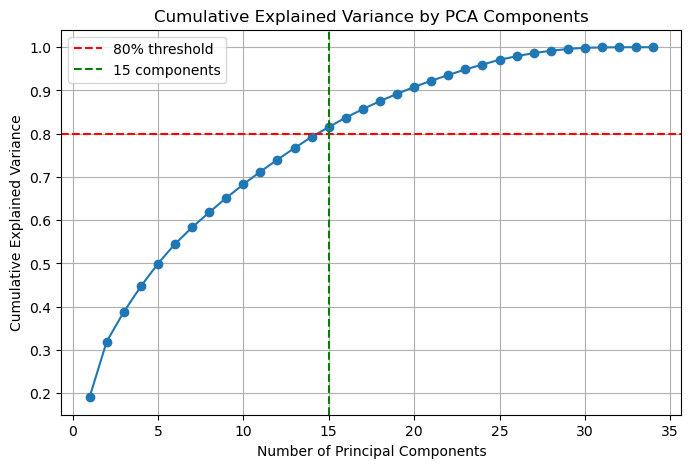

In [10]:
# Add principal components to DataFrame for plotting
allData['PC1'] = principal_components[:, 0]
allData['PC2'] = principal_components[:, 1]

# Explained variance
print("Explained variance ratio:", pca.explained_variance_ratio_)
print("Total explained variance (first 2 PCs):", np.sum(pca.explained_variance_ratio_))

# Fit PCA with all components
pca_full = PCA()
pca_full.fit(X_scaled)

# Calculate cumulative explained variance
cum_var = np.cumsum(pca_full.explained_variance_ratio_)

# Print how many components are needed for at least 80% explained variance
n_components_80 = np.argmax(cum_var >= 0.8) + 1
print(f"Number of components for at least 80% explained variance: {n_components_80}")

# Plot cumulative explained variance
plt.figure(figsize=(8,5))
plt.plot(range(1, len(cum_var)+1), cum_var, marker='o')
plt.axhline(0.8, color='red', linestyle='--', label='80% threshold')
plt.axvline(n_components_80, color='green', linestyle='--', label=f'{n_components_80} components')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance by PCA Components')
plt.legend()
plt.grid(True)
plt.show()

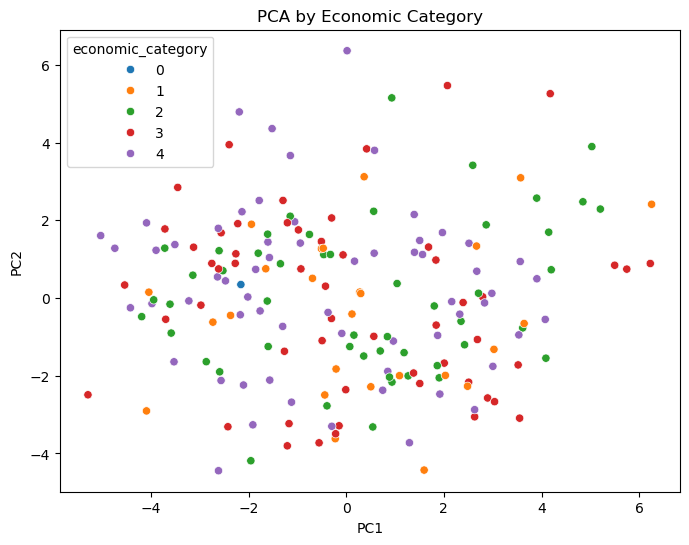

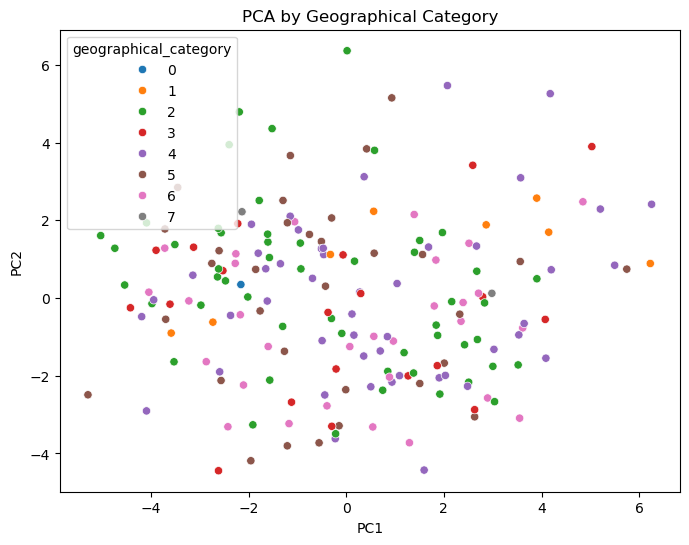

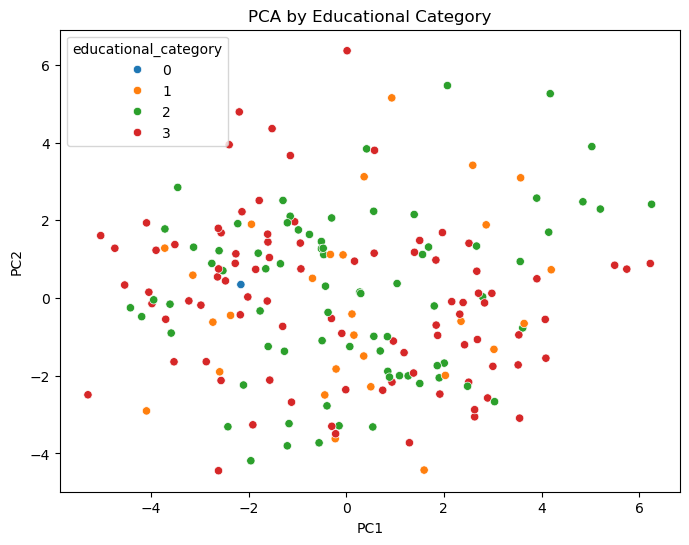

In [11]:
# Plot by economic category
plt.figure(figsize=(8,6))
sns.scatterplot(data=allData, x='PC1', y='PC2', hue='economic_category', palette='tab10')
plt.title('PCA by Economic Category')
plt.show()

# Plot by geographical category
plt.figure(figsize=(8,6))
sns.scatterplot(data=allData, x='PC1', y='PC2', hue='geographical_category', palette='tab10')
plt.title('PCA by Geographical Category')
plt.show()

# Plot by educational category
plt.figure(figsize=(8,6))
sns.scatterplot(data=allData, x='PC1', y='PC2', hue='educational_category', palette='tab10')
plt.title('PCA by Educational Category')
plt.show()

In [12]:
# Correlation between original features and the first two PCs
pc_df = pd.DataFrame(principal_components, columns=['PC1', 'PC2'])
corrs = pd.concat([pc_df, X.reset_index(drop=True)], axis=1).corr()
print("Correlation of original features with PC1:")
print(corrs['PC1'].sort_values(ascending=False))
print("\nCorrelation of original features with PC2:")
print(corrs['PC2'].sort_values(ascending=False))

Correlation of original features with PC1:


TypeError: DataFrame.sort_values() missing 1 required positional argument: 'by'

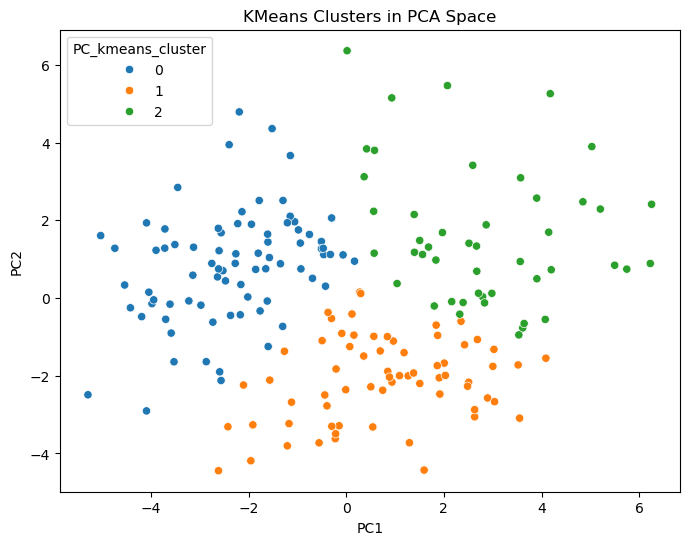

In [13]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3, random_state=42)
allData['PC_kmeans_cluster'] = kmeans.fit_predict(pc_df)

plt.figure(figsize=(8,6))
sns.scatterplot(data=allData, x='PC1', y='PC2', hue='PC_kmeans_cluster', palette='tab10')
plt.title('KMeans Clusters in PCA Space')
plt.show()

In [ ]:
# Crosstab to compare clusters and economic category
print(pd.crosstab(allData['PC_kmeans_cluster'], allData['economic_category']))
print(pd.crosstab(allData['PC_kmeans_cluster'], allData['geographical_category']))
print(pd.crosstab(allData['PC_kmeans_cluster'], allData['educational_category']))

economic_category   1   2   3   4
PC_kmeans_cluster                
0                  12  18  21  30
1                   5  12  10  18
2                   9  20  23  15
geographical_category  1   2  3   4   5   6  7
PC_kmeans_cluster                             
0                      3  25  9  17  16  10  1
1                      5  10  4  12   6   7  1
2                      0  17  7  19  11  13  0
educational_category   1   2   3
PC_kmeans_cluster               
0                     11  29  41
1                      7  17  21
2                     10  29  28


In [ ]:
# Print unassigned countries for each category

print("Unassigned countries in economic_category:")
print(allData.loc[allData['economic_category'] == 0, 'country'].unique())
print(len(allData.loc[allData['economic_category'] == 0, 'country'].unique()), "countries unassigned in economic_category")

print("\nUnassigned countries in geographical_category:")
print(allData.loc[allData['geographical_category'] == 0, 'country'].unique())
print(len(allData.loc[allData['geographical_category'] == 0, 'country'].unique()), "countries unassigned in geographical_category")

print("\nUnassigned countries in educational_category:")
print(allData.loc[allData['educational_category'] == 0, 'country'].unique())
print(len(allData.loc[allData['educational_category'] == 0, 'country'].unique()), "countries unassigned in educational_category")

Unassigned countries in economic_category:
[]
0 countries unassigned in economic_category

Unassigned countries in geographical_category:
[]
0 countries unassigned in geographical_category

Unassigned countries in educational_category:
[]
0 countries unassigned in educational_category


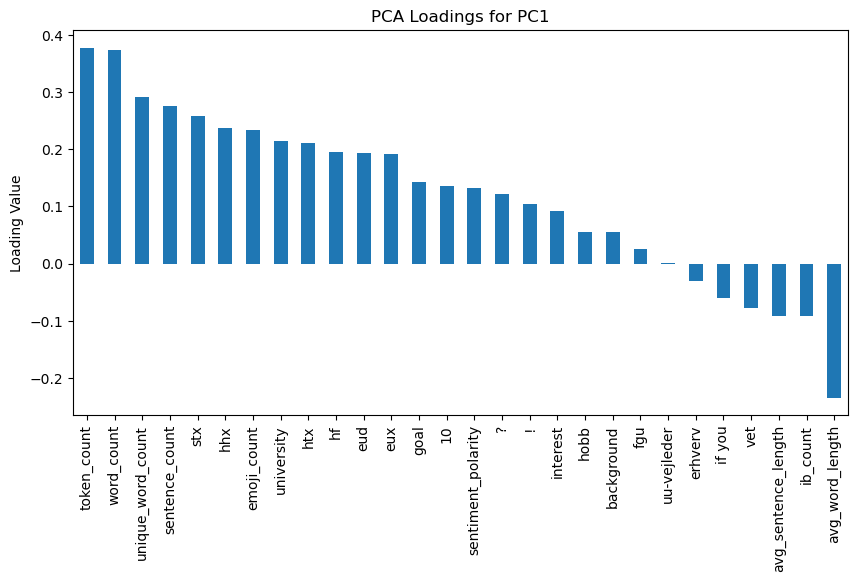

In [ ]:
# Get the loadings for the first principal component
loadings = pd.Series(pca_full.components_[0], index=X.columns)

# Plot the loadings for PC1
plt.figure(figsize=(10,5))
loadings.sort_values(ascending=False).plot(kind='bar')
plt.title('PCA Loadings for PC1')
plt.ylabel('Loading Value')
plt.show()

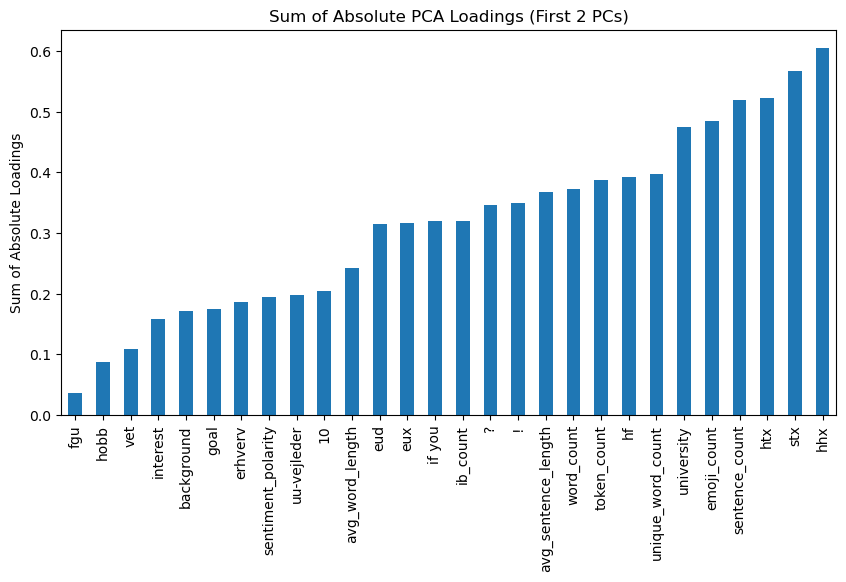

In [ ]:
# Sum absolute loadings across first N PCs (e.g., N=2)
N = 2
abs_loadings = np.abs(pca_full.components_[:N]).sum(axis=0)
feature_importance = pd.Series(abs_loadings, index=X.columns)
feature_importance.sort_values(ascending=True).plot(kind='bar', figsize=(10,5))
plt.title(f'Sum of Absolute PCA Loadings (First {N} PCs)')
plt.ylabel('Sum of Absolute Loadings')
plt.show()